# Quiz 2: Potential Flow
Starting up the environment and setting up key functions

In [9]:
import numpy as np
import matplotlib.pyplot as plt

# For masking the data
import numpy.ma as ma
from numpy.random import uniform

# Interpolation method
from scipy.interpolate import RectBivariateSpline as interp_2D

# For root-finding
from scipy.optimize import fsolve


def create_grid(Domain_x_min,Domain_x_max,Domain_z_min,Domain_z_max,dx,dz):
    """This function creates a 2D grid between xmin and xmax as well zmin and
    zmax with spacing dx and dz. The function also returns a vector (1D array)
    x and z coordinates"""

    # This command makes 1-D array (or vectors) for x and z axis
    # If you ever want to know just the x-coordinates or the z-coordinate
    # then jus t use xa and za or that
    xa= np.arange(Domain_x_min,Domain_x_max+dx,dx)
    za= np.arange(Domain_z_min,Domain_z_max+dx,dz)
    # This command makes a mesh (2-D array) using xa and za, This is now our
    # domain
    x,z = np.meshgrid(xa,za)
    return[xa,za,x,z]


def findvelocities(psi):
    """This command computes the w and u components of velocity as gradient
    (psi). The gradient along the columns is taken in first and then the rows.
    The function gradient computes the first derivative of a variable along a
    given axis."""
    u,w = np.gradient(psi)
    u = u/dz
    w = -1*w/dx

    return [u,w]


def findpressure(u,w,Uref):
    """This command computes the pressure coefficient from the velocities and a
    reference speed"""
    Cp = 1-((u**2+w**2)/Uref**2)
    return Cp


def mask_box(xms,xmf,zms,zmf,psi,u,w):
    """This function takes the four corners of a rectangular box and masks the
    data within the box"""
    psi_m = ma.masked_where((x > xms) & (x <= xmf) & (z > zms) & (z <= zmf), psi)
    u_m = ma.masked_where((x > xms) & (x <= xmf) & (z > zms) & (z <= zmf), u)
    w_m = ma.masked_where((x > xms) & (x <= xmf) & (z > zms) & (z <= zmf), w)
    return[psi_m,u_m,w_m]


def mask_data(val,val_min,val_max,psi,u,w):
    """This function masks data between a min and max value for a given parameter.
    We use 1 = psi, 2 = u and 3 = w"""
    if (val == 0):
        valf = psi
    if (val == 1):
        valf = u
    if (val == 2):
        valf = w

    psi_m = ma.masked_where((valf > val_min) & (valf < val_max), psi)
    u_m = ma.masked_where((valf > val_min) & (valf < val_max), u)
    w_m = ma.masked_where((valf > val_min) & (valf < val_max), w)
    return[psi_m,u_m,w_m]

def find_index(axis_vec,loc):
  """This function finds the nearest index in a vector that meets your condition"""
  #This finds x-index for the location
  difference_array = np.absolute(axis_vec-loc)
  # find the index of minimum element from the array
  index = difference_array.argmin()
  return index

def interpolate_values(xa,za,func,xl,zl):
  """This function takes the 1D array (or vector) of x and z coordinates as well as the 2D array of data that you want to interpolate. It porvide the value of the function at xl and zl points specified by you."""
  fun =  interp_2D(za, xa, func) #You dont need to use 2D array of x and y for this.
  #Just the 1D array with coordinates of y and x are needed.
  #You also need to pass y coordinates first and then the x coordinates
  interp_value = fun(zl,xl)[0] #This interpolates the values of the function f in the new set of points.
  #Note that you need to pass y coodinate first and then the x-coordinate
  return interp_value

# ------ Flows ------

def uniform_flow(Uinf,alpha):
  """This command is the stream function for Uniform flow. The input are Uinf and angle alpha (alpha is in degrees)"""
  psiu = Uinf*np.cos(np.pi*alpha/180)*z - Uinf*np.sin(np.pi*alpha/180)*x

  return psiu


def source(Q,x0,z0):
 """The input to this function is the strength and the location (x0,z0) of source/sink. Positive Q is source and negative Q is sink."""
 #This command finds the radial coordinate r from the cartesian coordinate
 #relative to this specific flow element

 r = np.sqrt((x-x0)**2+(z-z0)**2)

 #This command finds the tangential angle theta from the cartesian coordinate
 #relative to this specific flow element

 theta = np.arctan2(z-z0,x-x0)

 #This command is the stream function for source/sink
 psis = Q*theta/(2*np.pi)

 return psis


def doublet(Kappa,x0,z0):
  """The input to this function is the strength and the location (x0,z0) of the doublet. Positive doublet is source on the left and sink on the right. Negative doublet is sink on the left and source on ther right."""
  #This command finds the radial coordinate r from the cartesian coordinate
  #relative to this specific flow element
  r = np.sqrt((x-x0)**2+(z-z0)**2)

  #This command finds the tangential angle theta from the cartesian coordinate
  #relative to this specific flow element
  theta = np.arctan2(z-z0,x-x0)

  #This command is the stream function for source/sink
  psid = -Kappa*(z-z0)/(2*np.pi*r*r)

  return psid


def vortex(Gamma,x0,z0):
  """The input to this function is the circulation and the location (x0,z0) of the vortex. Positive Gamma is rotation in clockwise direction. Negative Gamma is rotation in counter-clockwise direction."""

  #This command finds the radial coordinate r from the cartesian coordinate
  #relative to this specific flow element
  r = np.sqrt((x-x0)**2+(z-z0)**2)

  #This command finds the tangential angle theta from the cartesian coordinate
  #relative to this specific flow element
  theta = np.arctan2(z-z0,x-x0)

  #This command is the stream function for a vortex
  psiv = Gamma*np.log(r)/(2*np.pi)

  return psiv

# Setting up Domain

In [35]:
Domain_x_min = -6
Domain_x_max = 6
Domain_z_min = -6
Domain_z_max = 6
dx = dz = 0.22

# We first create grid to compute the flow
[xa,za,x,z] = create_grid(Domain_x_min,Domain_x_max,Domain_z_min,Domain_z_max,dx,dz)

# Questions

A potential flow is generated by combining a uniform flow of 4.9 m/s and a source located at the origin with strength 1 m2/s. Find the mass flow rate per unit depth for this flow between two streamlines passing through points (2,5.6) and (1,2.7).

Assume the density of the fluid is 1 kg/m3.

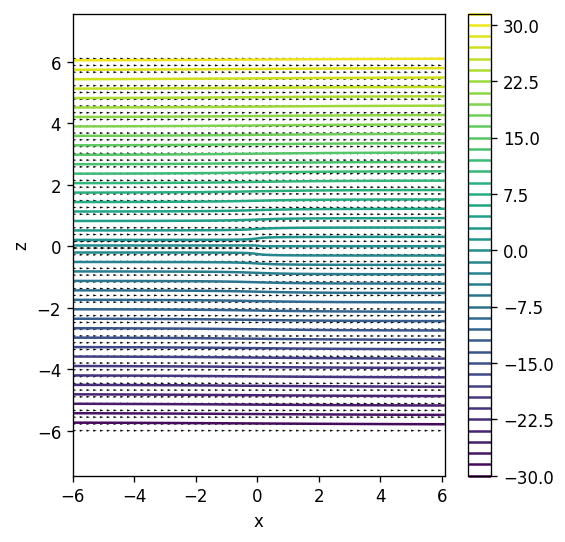

[-6.   -5.78 -5.56 -5.34 -5.12 -4.9  -4.68 -4.46 -4.24 -4.02 -3.8  -3.58
 -3.36 -3.14 -2.92 -2.7  -2.48 -2.26 -2.04 -1.82 -1.6  -1.38 -1.16 -0.94
 -0.72 -0.5  -0.28 -0.06  0.16  0.38  0.6   0.82  1.04  1.26  1.48  1.7
  1.92  2.14  2.36  2.58  2.8   3.02  3.24  3.46  3.68  3.9   4.12  4.34
  4.56  4.78  5.    5.22  5.44  5.66  5.88  6.1 ] [-6.   -5.78 -5.56 -5.34 -5.12 -4.9  -4.68 -4.46 -4.24 -4.02 -3.8  -3.58
 -3.36 -3.14 -2.92 -2.7  -2.48 -2.26 -2.04 -1.82 -1.6  -1.38 -1.16 -0.94
 -0.72 -0.5  -0.28 -0.06  0.16  0.38  0.6   0.82  1.04  1.26  1.48  1.7
  1.92  2.14  2.36  2.58  2.8   3.02  3.24  3.46  3.68  3.9   4.12  4.34
  4.56  4.78  5.    5.22  5.44  5.66  5.88  6.1 ]
9.460050272962835
5.152601208927284
Mass flow rate is: 4.31 kg/s


In [44]:
# PLOT FLOW ELEMENTS
Uinf = 4.9
alpha = 0
Q = 1
Gamma = 3.3

psi_flow = uniform_flow(Uinf, 0) + source(Q, 0, 0)
wall = 0
psi = psi_flow + wall

[u, w] = findvelocities(psi)

Cp = findpressure(u, w, Uinf)

plt.figure(figsize=(5, 5), dpi=120)

plt.contour(x, z, psi, 50)
plt.colorbar()
plt.quiver(x, z, u, w)
plt.axis('equal')
plt.xlabel('x')
plt.ylabel('z')


plt.show()

x1 = 2
z1 = 5.6
x2 = 1
z2 = 2.7

st1_x_index = find_index(xa, x1)
st1_z_index = find_index(za, z1)
psi_1 = psi[st1_x_index, st1_z_index]
print(psi_1)

st2_x_index = find_index(xa, x2)
st2_z_index = find_index(za, z2)
psi_2 = psi[st2_x_index, st2_z_index]
print(psi_2)

rho = 1
mdot = rho * (psi_1 - psi_2)
print(f"Mass flow rate is: {mdot:.2f} kg/s")